# HOML - Capítulo 3: Classificação

## 1. MNIST

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

In [3]:
# Carrega o dataset MNIST
mnists = fetch_openml('mnist_784', version = 1)

In [4]:
# Chaves para o dataset MNIST
mnists.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnists['data'], mnists['target']
X.shape, y.shape

((70000, 784), (70000,))

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

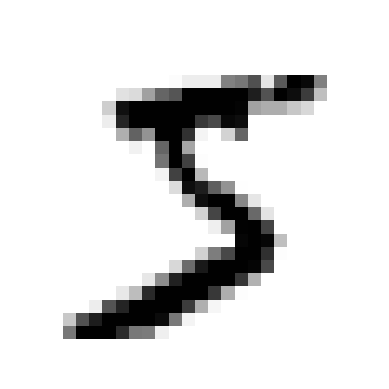

In [8]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis('off')
plt.show()

In [9]:
y[0]

'5'

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 2. Treinando um classificador binário

In [11]:
# True para todos os 5s, False para todos os outros algarismos
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [12]:
y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [13]:
# Importa o SGDClassifier
from sklearn.linear_model import SGDClassifier

In [14]:
# Treina o classificador SGDClassifier no dataset MNIST
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
# Utilizar o classificador para prever se um algarismo é 5 ou não
sgd_clf.predict([some_digit])

c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## 3. Cálculo de desempenho

### 3.1. Calculando a acurácia com a validação cruzada

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.base import BaseEstimator

In [19]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

### 3.2. Matriz de confusão

In [21]:
from sklearn.model_selection import cross_val_predict

In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [25]:
y_train_perfect_pred = y_train_5

In [26]:
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])

\begin{equation*}
\text{precisão} = \frac{TP}{TP + FP}, \quad \text{recall (revocação)} = \frac{TP}{TP + FN}
\end{equation*}



In [27]:
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [31]:
y_some_digit_pred

array([ True])

In [32]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [35]:
from sklearn.metrics import precision_recall_curve

In [36]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precisão")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])

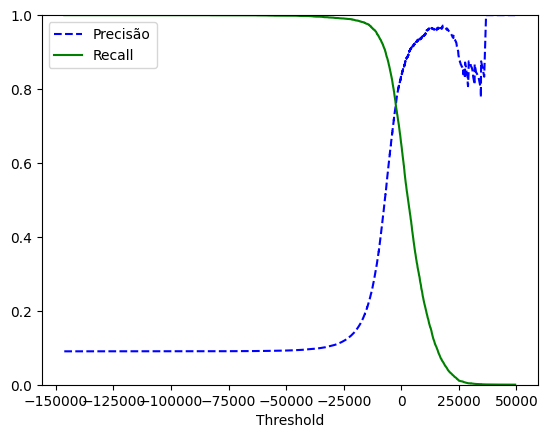

In [38]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [40]:
threshold_90_precision

np.float64(3370.0194991439557)

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3. A curva ROC

In [44]:
from sklearn.metrics import roc_curve

In [45]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [46]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, "b-", label = "ROC curve")
    plt.plot([0, 1], [0, 1], "r--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc = "lower right")
    plt.grid()

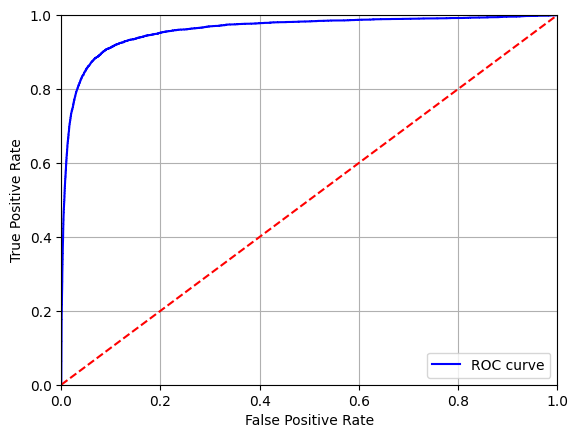

In [47]:
plot_roc_curve(fpr, tpr)

In [48]:
from sklearn.metrics import roc_auc_score

In [49]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
forest_clf = RandomForestClassifier(random_state = 42)

In [52]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

In [53]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]], shape=(60000, 2))

In [54]:
y_scores_forest = y_probas_forest[:, 1] # score = probabilidade de classe positiva, i.e., probabilidade de ser 5
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

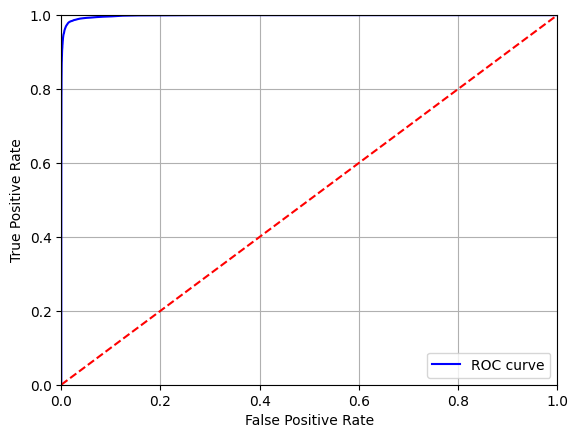

In [55]:
plot_roc_curve(fpr_forest, tpr_forest)

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [57]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

In [58]:
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(0.9905083315756169, 0.8662608374838591)

### 3.4. Classificação multiclasse

In [59]:
from sklearn.svm import SVC

In [60]:
svm_clf = SVC()

In [64]:
svm_clf.fit(X_train, y_train)

SVC()

In [65]:
svm_clf.predict([some_digit])

c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array(['5'], dtype=object)

In [66]:
some_digit_scores = svm_clf.decision_function([some_digit])

c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [67]:
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [68]:
np.argmax(some_digit_scores)

np.int64(5)

In [69]:
from sklearn.multiclass import OneVsRestClassifier

In [70]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not h

array(['5'], dtype='<U1')

In [71]:
len(ovr_clf.estimators_)

10

In [72]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array(['3'], dtype='<U1')

In [73]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3)

array([0.87365, 0.85835, 0.8689 ])

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [75]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

In [76]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

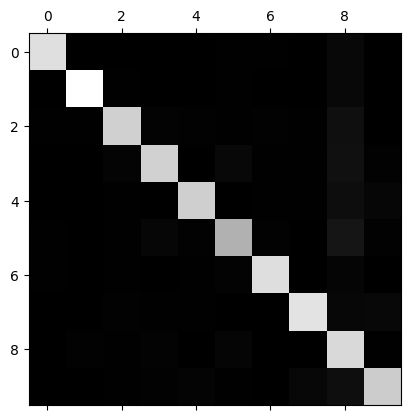

In [80]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

In [81]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

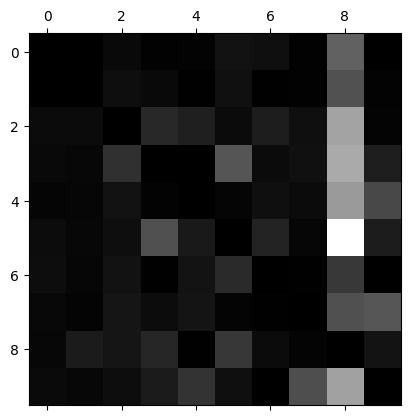

In [82]:
np.fill_diagonal(norm_conf_mx, 0)  # Zera a diagonal para melhor visualização
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [83]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

### 3.5. Classificação multirrótulo 

In [84]:
from sklearn.neighbors import KNeighborsClassifier

In [99]:
y_train_large = (y_train.astype(int) >= 7)
y_train_odd = (y_train.astype(int) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [102]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]], shape=(60000, 2))

In [106]:
from sklearn.metrics import f1_score
from sklearn.multioutput import MultiOutputClassifier   

In [104]:
knn_clf = MultiOutputClassifier(KNeighborsClassifier())
knn_clf.fit(X_train, y_multilabel)

MultiOutputClassifier(estimator=KNeighborsClassifier())

In [105]:
knn_clf.predict([some_digit])

c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\environments\DS_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [109]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_scaled, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")